In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
import os


Fitting 3 folds for each of 5 candidates, totalling 15 fits

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2451
           1       0.99      1.00      1.00       148
           2       1.00      0.99      0.99       244
           3       0.99      0.99      0.99       196

    accuracy                           1.00      3039
   macro avg       0.99      0.99      0.99      3039
weighted avg       1.00      1.00      1.00      3039



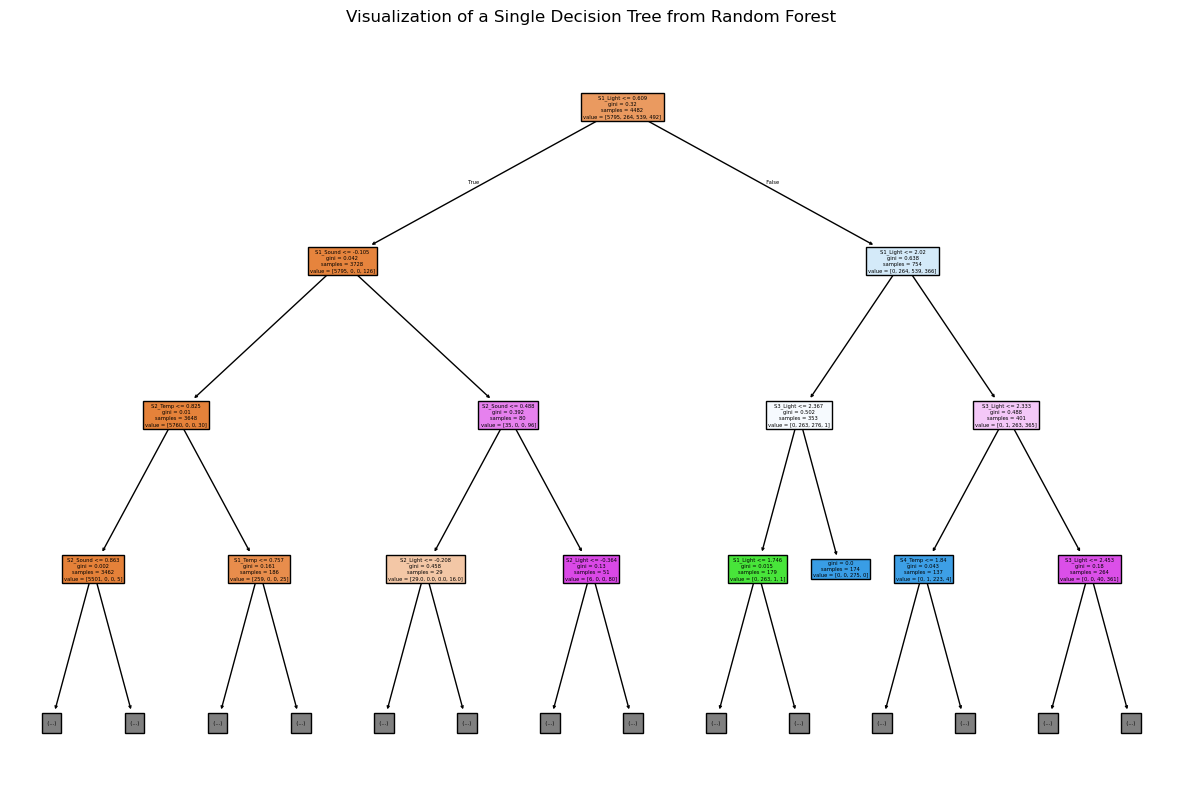

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Loading dataset
file_path = 'Occupancy_Estimation.csv'  
data = pd.read_csv(file_path)

#target columns & feautre columns
feature_columns = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 
                   'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound']
target_column = 'Room_Occupancy_Count'

# Checking if datacolumns exist or not
missing_features = [col for col in feature_columns if col not in data.columns]
if missing_features:
    raise KeyError(f"Some feature columns are missing: {missing_features}")
if target_column not in data.columns:
    raise KeyError(f"Target column is missing: {target_column}")

# Spliting feautres X & Y
X = data[feature_columns].values
y = data[target_column].values

# Scaling feautres
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the Random Forest Classifier and parameter grid
rf = RandomForestClassifier(oob_score=True, random_state=42)
rf_params = {
    "n_estimators": [50, 100],  
    "max_depth": [10, 15],  
    "min_samples_split": [2, 5],  
}

# Use RandomizedSearchCV for hyperparameter optimization
random_search_rf = RandomizedSearchCV(
    rf, rf_params, scoring="f1_weighted", cv=3, n_iter=5, verbose=1, n_jobs=-1, random_state=42
)
random_search_rf.fit(X_train, y_train)

# Get the best Random Forest model
best_rf = random_search_rf.best_estimator_

# Making predictions
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = (
    best_rf.predict_proba(X_test)[:, 1]
    if len(best_rf.classes_) == 2
    else best_rf.predict_proba(X_test)
)

# Evaluate the model
print("\n=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))

# Visualize one of the decision trees from the Random Forest
plt.figure(figsize=(15, 10))
plot_tree(best_rf.estimators_[0], feature_names=feature_columns, filled=True, max_depth=3)
plt.title("Visualization of a Single Decision Tree from Random Forest")
plt.savefig("random_forest_tree.png")
plt.show()


In [ ]:
#----------Logistic Regression--------------------


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Load the data
data = pd.read_csv('Occupancy_Estimation.csv', delimiter=',')

# Defining features X & Y
X = data.drop(columns=['Date', 'Time', 'Room_Occupancy_Count'])  
y = data['Room_Occupancy_Count'] 

# Check for binary or multiclass target
unique_classes = y.nunique()
print(f"Unique target classes: {unique_classes}")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
best_lr = LogisticRegression(max_iter=1000, random_state=42)
best_lr.fit(X_train, y_train)

# Define  evaluation function
def evaluate_model(y_true, y_pred, y_proba, model_name, multiclass=False):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(
            y_true, y_pred, average="weighted" if multiclass else "binary"
        ),
        "Recall": recall_score(
            y_true, y_pred, average="weighted" if multiclass else "binary"
        ),
        "F1-Score": f1_score(
            y_true, y_pred, average="weighted" if multiclass else "binary"
        ),
    }

    # ROC-AUC Score
    if multiclass:
        metrics["ROC-AUC"] = roc_auc_score(
            y_true, y_proba, multi_class="ovr", average="weighted"
        )
    else:
        metrics["ROC-AUC"] = roc_auc_score(y_true, y_proba)

    print(f"--- {model_name} Evaluation ---")
    for metric, score in metrics.items():
        print(f"{metric}: {score:.4f}")

    return metrics

# Making predictions
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = (
    best_lr.predict_proba(X_test) if unique_classes > 2 else best_lr.predict_proba(X_test)[:, 1]
)

# Evaluate  model
is_multiclass = unique_classes > 2
lr_metrics = evaluate_model(y_test, y_pred_lr, y_proba_lr, "Logistic Regression", multiclass=is_multiclass)


Unique target classes: 4
--- Logistic Regression Evaluation ---
Accuracy: 0.9872
Precision: 0.9876
Recall: 0.9872
F1-Score: 0.9872
ROC-AUC: 0.9981


d:\Games\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Training Support Vector Machine (SVM) ===
{'0': {'precision': 0.9979608482871125, 'recall': 0.9983680130558955, 'f1-score': 0.9981643891495003, 'support': 2451.0}, '1': {'precision': 0.9866666666666667, 'recall': 1.0, 'f1-score': 0.9932885906040269, 'support': 148.0}, '2': {'precision': 0.9954545454545455, 'recall': 0.8975409836065574, 'f1-score': 0.9439655172413793, 'support': 244.0}, '3': {'precision': 0.8709677419354839, 'recall': 0.9642857142857143, 'f1-score': 0.9152542372881356, 'support': 196.0}, 'accuracy': 0.9881539980256664, 'macro avg': {'precision': 0.9627624505859522, 'recall': 0.9650486777370418, 'f1-score': 0.9626681835707604, 'support': 3039.0}, 'weighted avg': {'precision': 0.9890191814177832, 'recall': 0.9881539980256664, 'f1-score': 0.9882280506515934, 'support': 3039.0}}


d:\Games\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


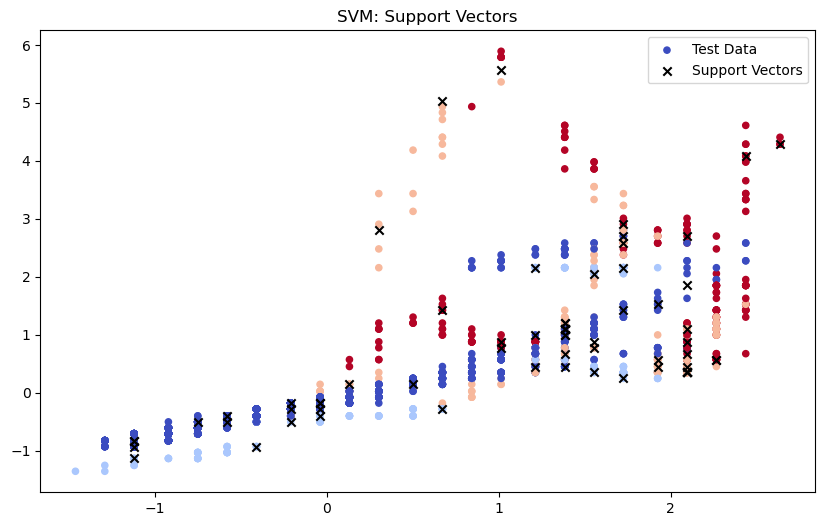


Saving Results...
Results saved!


In [ ]:
#----------------------SVM(Support Vector Machine)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Loading  dataset
file_path = 'Occupancy_Estimation.csv'  
data = pd.read_csv(file_path)

# Print the first few rows of the dataset to check column names
#print("Dataset Columns:", data.columns)    {if print needed comment out}
#print(data.head())                         {if print needed comment out}




# Define feature and target columns
feature_columns = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 
                   'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 
                   'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 
                   'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'] 
target_column = 'Room_Occupancy_Count'  

# Ensure the feature and target columns exist in the dataset
if not set(feature_columns).issubset(data.columns):
    raise KeyError(f"Some feature columns are missing: {feature_columns}")
if target_column not in data.columns:
    raise KeyError(f"Target column is missing: {target_column}")

# Split into features (X) and target (y)
X = data[feature_columns].values
y = data[target_column].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# For testing purposes, reduce the size of the training set (this line is optional)
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)


# Training SVM with Basic Configuration
#----------------------------
print("\n=== Training Support Vector Machine (SVM) ===")

# Train a basic linear SVM without hyperparameter tuning
svm_model = SVC(kernel='linear', C=1, probability=True, random_state=42, max_iter=1000)  
svm_model.fit(X_train_sample, y_train_sample)


# Evaluate SVM Model---------------------
# --------------------------------------
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Classification Report (accuracy, precision, recall, F1-score)
svm_report = classification_report(y_test, y_pred_svm, output_dict=True)  
print(svm_report)


# Plot Support Vectors-------------------
#------------------------------------------------------------------
# Visualize the SVM results(using 2D for simplicity)
plt.figure(figsize=(10, 6))

#If features are more than 2 then can plot 2D projection(PCA ,TSNE)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', s=20, label="Test Data")
plt.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], color='k', marker='x', label="Support Vectors")
plt.title("SVM: Support Vectors")
plt.legend()

# Saving plot
plt.savefig("results/plots/svm_support_vectors.png")
plt.show()

# -----------------------------------
# Save Results to CSV
print("\nSaving Results...")

# Create a DataFrame to save the results
results = pd.DataFrame({
    "Model": ["Support Vector Machine"],
    "Accuracy": [svm_report['accuracy']],
    "Precision": [svm_report['weighted avg']['precision']],
    "Recall": [svm_report['weighted avg']['recall']],
    "F1-Score": [svm_report['weighted avg']['f1-score']],
})

# Save the results as a CSV file
results.to_csv("results/svm_model_results.csv", index=False)
print("Results saved!")
